In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

In [36]:
import os
import pandas as pd

In [37]:
# Установка необходимых библиотек (если не установлены)
!pip install optuna catboost lightgbm xgboost prophet --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import xgboost as xgb
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [38]:
INPUT_CSV = '/kaggle/input/cafe_f_engin_EDA.csv'

In [39]:
df= pd.read_csv(INPUT_CSV)
df.head(2)

,ts,Количество блюд,Тип оплаты,Торговое предприятие,"Сумма со скидкой, р.","Сумма без скидки, р.",Наценка(%),"Себестоимость, р.",Себестоимость(%),holiday_name,...,dow,is_weekend,precip_flag,rain_flag,snow_flag,t_bin,hot,cold,windy,icy_snow
0,2021-04-06 15:48:05+03:00,1,Наличные,Энгельса,60.0,60.0,1.1761,27.5725,0.4595,Рабочий день,...,1,0,1,1,0,0..5,0,0,1,0
1,2021-04-06 15:48:05+03:00,1,Наличные,Энгельса,90.0,90.0,1.5714,35.0000,0.3889,Рабочий день,...,1,0,1,1,0,0..5,0,0,1,0


Этап 2. Загрузка и базовая подготовка данных

In [40]:
def load_and_prepare_data(filepath):
    df = pd.read_csv(filepath)
    # Преобразуем даты
    df['ts'] = pd.to_datetime(df['ts'])
    df['date'] = pd.to_datetime(df['date'])
    # Сортировка по времени
    df = df.sort_values('ts')
    return df

In [41]:
def handle_outliers(df, columns):
    """
    Обрезает выбросы по 1 и 99 перцентилю и создает флаговые признаки выбросов.
    df: DataFrame
    columns: список признаков для обработки
    """
    for col in columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        # Флаг выброса
        df[f'{col}_outlier'] = ((df[col] < lower) | (df[col] > upper)).astype(int)
        # Обрезка
        df[col] = df[col].clip(lower, upper)
    return df

Этап 3. Агрегация данных по нужным срезам

In [42]:
def aggregate_data(df, group_by, target_cols, agg_funcs):
    """ group_by: list of columns (например, ['date', 'Торговое предприятие'])
    target_cols: list of columns to aggregate (например, ['Количество блюд', 'Сумма со скидкой, р.'])
    agg_funcs: dict, например {'Количество блюд': 'sum', 'Сумма со скидкой, р.': 'sum'} """
    agg_df = df.groupby(group_by)[target_cols].agg(agg_funcs).reset_index()
    return agg_df

In [43]:
# Пример: агрегировать по дням и предприятиям
daily_enterprise = aggregate_data(df,
    ['date', 'Торговое предприятие'],
    ['Количество блюд', 'Сумма со скидкой, р.'],
    {'Количество блюд':'sum', 'Сумма со скидкой, р.':'sum'})

Этап 4. Подготовка данных для моделей

In [44]:
def prepare_features(df, features, target, test_size=0.2, time_series=True):
    """ features: список признаков
    target: целевая переменная
    """
    X = df[features]
    y = df[target]
    if time_series:
      split_idx = int(len(df)*(1-test_size))
      X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
      y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    else:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    return X_train, X_test, y_train, y_test

Этап 5. Обёртки для моделей и Optuna

In [45]:
def objective_lgbm(trial, X_train, y_train, X_valid, y_valid, cat_features):

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'random_state': 42,
        'verbose': -1  # Добавляем для подавления лишних сообщений
    }

    # Добавляем проверку на доступность GPU
    try:
        import torch
        params['device'] = 'gpu'
    except ImportError:
        print("GPU не доступен, используется CPU")

    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features, free_raw_data=False)
    valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features, free_raw_data=False)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(50),
            lgb.log_evaluation(0)
        ]
    )
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

def train_lgbm_optuna(X_train, y_train, X_valid, y_valid, cat_features, n_trials=20):
    study = optuna.create_study(direction='minimize')

    objective_with_data = lambda trial: objective_lgbm(
        trial, X_train, y_train, X_valid, y_valid, cat_features
    )

    study.optimize(objective_with_data, n_trials=n_trials, show_progress_bar=True)

    # Обучаем финальную модель с лучшими параметрами
    best_params = study.best_params

    # Преобразуем категориальные признаки в правильный формат для LightGBM
    for feature in cat_features:
        X_train[feature] = X_train[feature].astype('category')
        X_valid[feature] = X_valid[feature].astype('category')

    model = lgb.LGBMRegressor(**best_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        categorical_feature=cat_features,
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
    )

    return model, study


def objective_xgb(trial, X_train, y_train, X_valid, y_valid, cat_features):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'gpu_hist',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'random_state': 42,
    }
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    evals = [(dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=50, verbose_eval=False)
    preds = model.predict(dvalid)
    return mean_absolute_error(y_valid, preds)

def train_xgb_optuna(X_train, y_train, X_valid, y_valid, cat_features, n_trials=20):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective_xgb(trial, X_train, y_train, X_valid, y_valid, cat_features), n_trials=n_trials)
    best_params = study.best_params
    best_params.update({'objective':'reg:squarederror', 'eval_metric':'rmse', 'tree_method':'gpu_hist', 'random_state':42})
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    evals = [(dvalid, 'eval')]
    model = xgb.train(best_params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=50, verbose_eval=False)
    return model, study

def objective_catboost(trial, X_train, y_train, X_valid, y_valid, cat_features):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': 42,
        'task_type': 'GPU'
    }
    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=cat_features, early_stopping_rounds=50)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

def train_catboost_optuna(X_train, y_train, X_valid, y_valid, cat_features, n_trials=20):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective_catboost(trial, X_train, y_train, X_valid, y_valid, cat_features), n_trials=n_trials)
    best_params = study.best_params
    best_params.update({'loss_function':'RMSE', 'eval_metric':'RMSE', 'random_seed':42, 'task_type':'GPU'})
    model = CatBoostRegressor(**best_params, verbose=0)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=cat_features, early_stopping_rounds=50)
    return model, study

def objective_prophet(trial, train_df, valid_df, regressors):
    params = { 'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
              'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10.0, log=True),
              'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10.0, log=True),
              'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
              'yearly_seasonality': True,
              'weekly_seasonality': True,
              'daily_seasonality': False,}
    model = Prophet(**params)
    # Добавляем регрессоры
    for reg in regressors:
      model.add_regressor(reg)
    model.fit(train_df)
    forecast = model.predict(valid_df[['ds'] + regressors])
    preds = forecast['yhat'].values
    return mean_absolute_error(valid_df['y'], preds)

def train_prophet_optuna(train_df, valid_df, regressors, n_trials=20):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial:
                   objective_prophet(trial, train_df, valid_df, regressors), n_trials=n_trials)
    best_params = study.best_params
    best_params.update({'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False})
    model = Prophet(**best_params)
    for reg in regressors:
      model.add_regressor(reg)
    model.fit(train_df)
    return model, study

Этап 6. Оценка моделей и визуализация, важность признаков, предсказание на будущие периоды

In [46]:
def evaluate_model(model, X_test, y_test, model_name='Model', model_type='sklearn', features=None):
    """ model_type: 'catboost', 'lgbm', 'xgb', 'prophet' features: список признаков (для xgb) """
    if model_type == 'prophet': # X_test должен содержать 'ds', 'y' и все регрессоры
        forecast = model.predict(X_test)
        preds = forecast['yhat'].values
        y_true = X_test['y'].values
    elif model_type == 'xgb':
        dtest = xgb.DMatrix(X_test[features], enable_categorical=True)
        preds = model.predict(dtest)
        y_true = y_test.values
    else:
        preds = model.predict(X_test)
        y_true = y_test.values

    mae = mean_absolute_error(y_true, preds)
    try:
      rmse = mean_squared_error(y_true, preds, squared=False)
    except TypeError:
      rmse = np.sqrt(mean_squared_error(y_true, preds))
    print(f'{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}')
    plt.figure(figsize=(12,4))
    plt.plot(y_true, label='True')
    plt.plot(preds, label='Predicted')
    plt.title(f'{model_name} - True vs Predicted')
    plt.legend()
    plt.show()
    return mae, rmse, preds

def plot_feature_importance(model, feature_names, model_type='catboost', top_n=20, save_path=None):
    if model_type == 'catboost':
        importances = model.get_feature_importance()
        importances = 100 * importances / importances.sum()
    elif model_type == 'lgbm':
        importances = model.feature_importances_
        importances = 100 * importances / importances.sum()
    elif model_type == 'xgb':
        score = model.get_score(importance_type='weight')
        # Используем реальные имена признаков!
        importances = np.array([score.get(f, 0) for f in feature_names])
        if importances.sum() > 0:
            importances = 100 * importances / importances.sum()
    else:
        print('Важность признаков не поддерживается для Prophet.')
        return
    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[indices], importances[indices], color='skyblue')
    plt.xlabel('Важность признака (%)', fontsize=12)
    plt.ylabel('Признак', fontsize=12)
    plt.title(f'Важность признаков: {model_type}', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    for i, v in enumerate(importances[indices]):
        plt.text(v, i, f'{v:.2f}%', va='center', fontsize=10)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()

def predict_future(model, future_df, features, model_type='sklearn'):
    """ model_type: 'catboost', 'lgbm', 'xgb', 'sklearn' features: список признаков для предсказания """
    if model_type == 'xgb':
        dtest = xgb.DMatrix(future_df[features], enable_categorical=True)
        preds = model.predict(dtest)
    elif model_type == 'catboost':
        preds = model.predict(future_df[features])
    elif model_type == 'lgbm':
        preds = model.predict(future_df[features])
    else:
        # sklearn-like
        preds = model.predict(future_df[features])
    return preds

def predict_future_prophet(model, future_df):
    """ future_df должен содержать 'ds' и все регрессоры, которые использовались при обучении. """
    forecast = model.predict(future_df)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [47]:
class DemandRevenuePredictor:
    def init(self, df):
        self.df = df

    def aggregate(self, group_by, target_cols, agg_funcs):
        return aggregate_data(self.df, group_by, target_cols, agg_funcs)

    def train_model(self, X_train, y_train, X_valid, y_valid, cat_features=None, n_trials=20, model_type='catboost', regressors=None):
        if model_type == 'catboost':
            model, study = train_catboost_optuna(X_train, y_train, X_valid, y_valid, cat_features, n_trials)
        elif model_type == 'lgbm':
            model, study = train_lgbm_optuna(X_train, y_train, X_valid, y_valid, cat_features, n_trials)
        elif model_type == 'xgb':
            model, study = train_xgb_optuna(X_train, y_train, X_valid, y_valid, cat_features, n_trials)
        elif model_type == 'prophet':
            model, study = train_prophet_optuna(X_train, y_train, regressors, n_trials)
        else:
            raise ValueError("Unknown model_type")
        return model, study

    def evaluate(self, model, X_test, y_test, model_name='Model', model_type='catboost', features=None):
        return evaluate_model(model, X_test, y_test, model_name, model_type, features)

    def feature_importance(self, model, feature_names, model_type='catboost', top_n=20):
        plot_feature_importance(model, feature_names, model_type, top_n)

    def predict(self, model, future_df, features, model_type='catboost'):
        return predict_future(model, future_df, features, model_type)

    def predict_prophet(self, model, future_df):
        return predict_future_prophet(model, future_df)

In [48]:
def sync_categories(X_train, X_test, cat_features):
    """Синхронизирует категориальные признаки между train и test"""
    X_train_sync = X_train.copy()
    X_test_sync = X_test.copy()
    real_cat_features = []
    cat_categories = {}
    for feature in cat_features:
        if feature in X_train.columns:
            train_cat = pd.Categorical(X_train[feature])
            test_cat = pd.Categorical(X_test[feature])
            all_categories = pd.concat([
                pd.Series(train_cat),
                pd.Series(test_cat)
            ]).astype('category').cat.categories
            X_train_sync[feature] = pd.Categorical(X_train[feature], categories=all_categories)
            X_test_sync[feature] = pd.Categorical(X_test[feature], categories=all_categories)
            real_cat_features.append(feature)
            cat_categories[feature] = all_categories
    return X_train_sync, X_test_sync, real_cat_features, cat_categories

from sklearn.model_selection import TimeSeriesSplit

def universal_pipeline(
    filepath, group_by, target_cols, agg_funcs, features, target,
    cat_features, regressors, n_trials=20, test_size=0.2, n_splits=5
):
    # 1. Загрузка и подготовка
    df = load_and_prepare_data(filepath)
    # a) Агрегация по нескольким признакам (например, дата и предприятие)
    agg_df = aggregate_data(df, group_by, target_cols, agg_funcs)
    agg_df = handle_outliers(agg_df, ['precip'])

    # e) Валидация: TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_idx, test_idx in tscv.split(agg_df):
        X_train, X_test = agg_df.iloc[train_idx][features], agg_df.iloc[test_idx][features]
        y_train, y_test = agg_df.iloc[train_idx][target], agg_df.iloc[test_idx][target]

        # 2.1 Для LightGBM: синхронизируем категории
        X_train_sync, X_test_sync, real_cat_features, cat_categories = sync_categories(
            X_train, X_test, cat_features
        )

        # 2.2 Для XGBoost: просто приводим к category (без sync)
        X_train_xgb = X_train_sync.copy()
        X_test_xgb = X_test_sync.copy()
        for feature in real_cat_features:
            X_train_xgb[feature] = X_train_xgb[feature].cat.codes
            X_test_xgb[feature] = X_test_xgb[feature].cat.codes

        # Обучение моделей
        model_cat, study_cat = train_catboost_optuna(
            X_train_sync, y_train, X_test_sync, y_test, real_cat_features, n_trials
        )
        evaluate_model(model_cat, X_test_sync, y_test, model_name='CatBoost', model_type='catboost')

        model_lgbm, study_lgbm = train_lgbm_optuna(
            X_train_sync, y_train, X_test_sync, y_test, real_cat_features, n_trials
        )
        evaluate_model(model_lgbm, X_test_sync, y_test, model_name='LightGBM', model_type='lgbm')

        model_xgb, study_xgb = train_xgb_optuna(
            X_train_xgb, y_train, X_test_xgb, y_test, cat_features, n_trials
        )
        evaluate_model(model_xgb, X_test_xgb, y_test, model_name='XGBoost', model_type='xgb', features=features)

    # Prophet
    prophet_df = agg_df.rename(columns={target: 'y', group_by[0]: 'ds'})
    split_idx = int(len(prophet_df)*(1-test_size))
    train_df, valid_df = prophet_df.iloc[:split_idx], prophet_df.iloc[split_idx:]
    model_prophet, study_prophet = train_prophet_optuna(train_df, valid_df, regressors, n_trials)
    evaluate_model(model_prophet, valid_df, valid_df['y'], model_name='Prophet', model_type='prophet')

    # Прогнозирование на будущее для всех предприятий
    last_date = agg_df['date'].max()
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=7, freq='D')
    enterprises = agg_df['Торговое предприятие'].unique()
    future_df = pd.DataFrame([
        {'date': date, 'Торговое предприятие': ent}
        for date in future_dates
        for ent in enterprises
    ])
    future_df['month'] = future_df['date'].dt.month
    future_df['dow'] = future_df['date'].dt.dayofweek
    future_df['season'] = ((future_df['month']%12 + 3)//3)
    for col in features:
        if col not in future_df.columns:
            future_df[col] = 0

    # Для Prophet
    future_prophet = future_df.rename(columns={'date': 'ds'})
    for reg in regressors:
        if reg not in future_prophet.columns:
            future_prophet[reg] = 0

    # --- СИНХРОНИЗАЦИЯ КАТЕГОРИЙ ДЛЯ future_df ---
    for f in real_cat_features:
        if f in future_df.columns:
            future_df[f] = pd.Categorical(future_df[f], categories=cat_categories[f])

    # Для XGBoost: преобразуем категории в коды
    future_df_xgb = future_df.copy()
    for f in real_cat_features:
        if f in future_df_xgb.columns:
            future_df_xgb[f] = pd.Categorical(future_df_xgb[f], categories=cat_categories[f])
            future_df_xgb[f] = future_df_xgb[f].cat.codes

    # Прогнозы
    preds_cat = predict_future(model_cat, future_df, features, model_type='catboost')
    preds_lgbm = predict_future(model_lgbm, future_df, features, model_type='lgbm')
    preds_xgb = predict_future(model_xgb, future_df_xgb, features, model_type='xgb')
    preds_prophet = predict_future_prophet(model_prophet, future_prophet)

    return {
        'catboost': model_cat,
        'lgbm': model_lgbm,
        'xgb': model_xgb,
        'prophet': model_prophet,
        'future_preds': {
            'catboost': preds_cat,
            'lgbm': preds_lgbm,
            'xgb': preds_xgb,
            'prophet': preds_prophet
        },
        'X_test_sync': X_test_sync,
        'X_test_xgb': X_test_xgb,
        'y_test': y_test,
        'valid_df': valid_df,
        'future_df': future_df
    }


In [49]:
agg_funcs = {
    'Количество блюд': 'sum',
    'Сумма со скидкой, р.': 'sum',
    'is_holiday': 'max',
    't_mean': 'mean',
    't_max': 'max',
    't_min': 'min',
    'precip': 'sum',
    'snowfall_sum': 'sum',
    'wind_mean': 'mean',
    'humidity': 'mean',
    'is_weekend': 'max',
    'hot': 'sum',
    'cold': 'sum',
    'windy': 'sum',
    'icy_snow': 'sum',
    'month': 'first',
    'dow': 'first',
    'season': 'first'
}

features = [
    'Торговое предприятие',  # обязательно!
    'month', 'dow', 'season', 'is_holiday', 't_mean', 't_max', 't_min',
    'precip', 'snowfall_sum', 'wind_mean', 'humidity', 'is_weekend',
    'hot', 'cold', 'windy', 'icy_snow'
]

cat_features = [
    'Торговое предприятие', 'season', 'dow', 'is_holiday', 'is_weekend'
]

regressors = [
    'is_holiday', 't_mean', 'precip', 'wind_mean', 'humidity'
    # только те, которые реально есть в prophet_df
]

Вызов функции

[I 2025-10-27 16:18:33,214] A new study created in memory with name: no-name-2beae8e2-d2d1-4c9a-a1ef-ae7aa3030409
[I 2025-10-27 16:18:37,330] Trial 0 finished with value: 488.2242744979633 and parameters: {'iterations': 195, 'depth': 10, 'learning_rate': 0.13382503842611837}. Best is trial 0 with value: 488.2242744979633.
[I 2025-10-27 16:18:41,596] Trial 1 finished with value: 427.64685083334166 and parameters: {'iterations': 584, 'depth': 9, 'learning_rate': 0.17333022030105713}. Best is trial 1 with value: 427.64685083334166.
[I 2025-10-27 16:18:42,776] Trial 2 finished with value: 370.2535155464335 and parameters: {'iterations': 112, 'depth': 4, 'learning_rate': 0.0832198236397688}. Best is trial 2 with value: 370.2535155464335.
[I 2025-10-27 16:18:44,664] Trial 3 finished with value: 343.12982360108094 and parameters: {'iterations': 456, 'depth': 4, 'learning_rate': 0.24774925489357022}. Best is trial 3 with value: 343.12982360108094.
[I 2025-10-27 16:18:46,292] Trial 4 finished w

CatBoost - MAE: 343.13, RMSE: 512.61


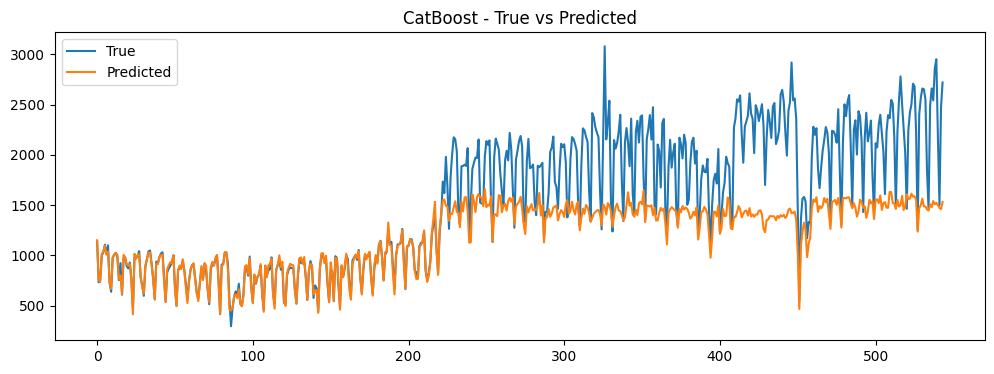

[I 2025-10-27 16:20:41,576] A new study created in memory with name: no-name-70fa8ce8-38e7-4fc9-bfe5-5582b4bf8201


  0%|          | 0/40 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's rmse: 503.376
[I 2025-10-27 16:20:42,127] Trial 0 finished with value: 334.7152841223486 and parameters: {'learning_rate': 0.2771515098426271, 'num_leaves': 95, 'max_depth': 10, 'feature_fraction': 0.8930295016817871, 'bagging_fraction': 0.7101282705620753, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 0 with value: 334.7152841223486.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's rmse: 560.956
[I 2025-10-27 16:20:42,560] Trial 1 finished with value: 381.65462771838185 and parameters: {'learning_rate': 0.1597474326852214, 'num_leaves': 121, 'max_depth': 12, 'feature_fraction': 0.7588686721048189, 'bagging_fraction': 0.9270554650200684, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 0 with value: 334.7152841223486.
Training until validation scores don't improve for 50 rounds
Di

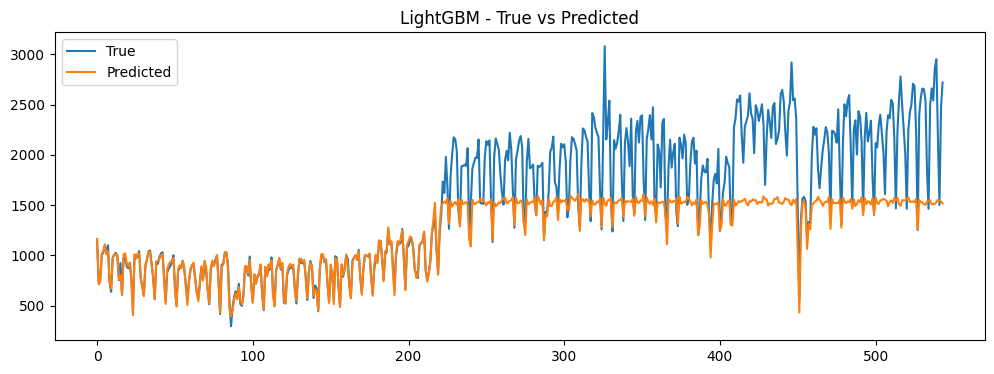

[I 2025-10-27 16:20:54,938] A new study created in memory with name: no-name-acf8374e-c52b-465f-baca-b1ccfe573700
[I 2025-10-27 16:20:55,226] Trial 0 finished with value: 401.27263355255127 and parameters: {'learning_rate': 0.26823048285778583, 'max_depth': 8, 'subsample': 0.9771315362468613, 'colsample_bytree': 0.684713109039753, 'min_child_weight': 2, 'gamma': 4.218961509477511, 'lambda': 1.9942476755614569, 'alpha': 0.022002974924606983}. Best is trial 0 with value: 401.27263355255127.
[I 2025-10-27 16:20:56,058] Trial 1 finished with value: 384.78249572305117 and parameters: {'learning_rate': 0.02932296123310714, 'max_depth': 6, 'subsample': 0.6590104353778294, 'colsample_bytree': 0.7788137962464786, 'min_child_weight': 13, 'gamma': 4.915326062637176, 'lambda': 0.0016192694662478368, 'alpha': 0.3694801731530531}. Best is trial 1 with value: 384.78249572305117.
[I 2025-10-27 16:20:56,890] Trial 2 finished with value: 304.23661781759824 and parameters: {'learning_rate': 0.25807444820

XGBoost - MAE: 285.70, RMSE: 437.23


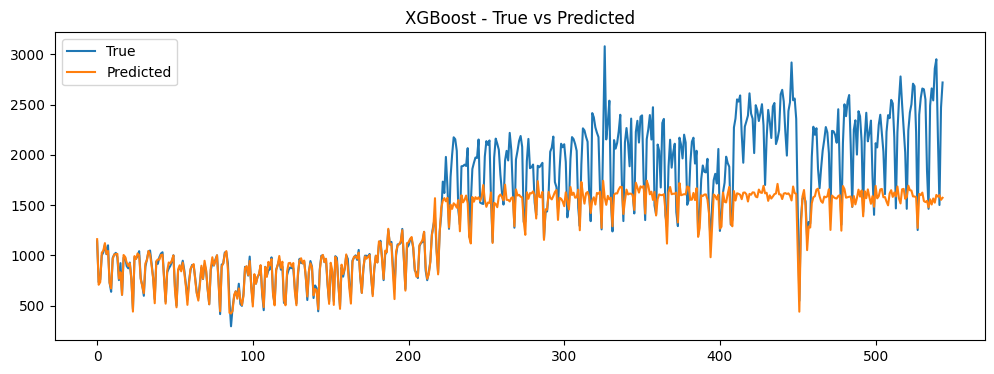

[I 2025-10-27 16:21:13,071] A new study created in memory with name: no-name-77b63f9d-dd94-4afc-9859-7bc53842961f
[I 2025-10-27 16:21:15,127] Trial 0 finished with value: 40.75435688463893 and parameters: {'iterations': 195, 'depth': 6, 'learning_rate': 0.2136844511940754}. Best is trial 0 with value: 40.75435688463893.
[I 2025-10-27 16:21:18,849] Trial 1 finished with value: 50.856579740415356 and parameters: {'iterations': 231, 'depth': 7, 'learning_rate': 0.11077997680596226}. Best is trial 0 with value: 40.75435688463893.
[I 2025-10-27 16:21:25,602] Trial 2 finished with value: 28.54124989310914 and parameters: {'iterations': 881, 'depth': 4, 'learning_rate': 0.09290991286272468}. Best is trial 2 with value: 28.54124989310914.
[I 2025-10-27 16:21:36,865] Trial 3 finished with value: 33.263187873527606 and parameters: {'iterations': 631, 'depth': 6, 'learning_rate': 0.028680784684352457}. Best is trial 2 with value: 28.54124989310914.
[I 2025-10-27 16:21:50,256] Trial 4 finished wit

CatBoost - MAE: 27.46, RMSE: 39.32


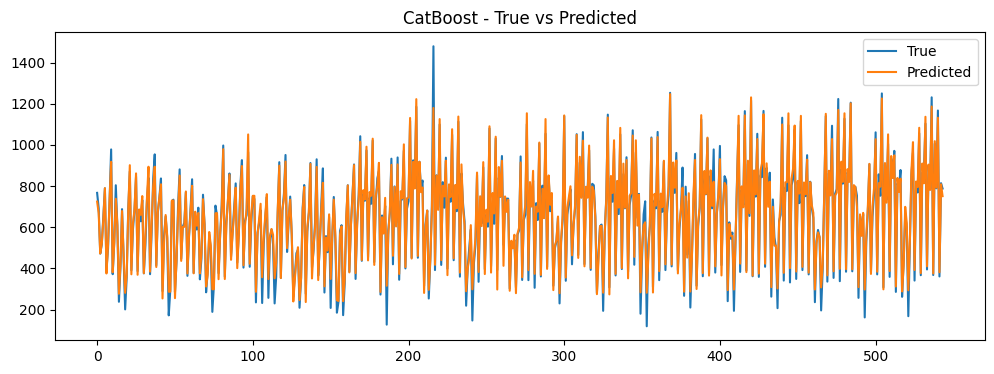

[I 2025-10-27 16:25:20,409] A new study created in memory with name: no-name-8eb8f273-054a-4fac-907d-1cb616d50ac7


  0%|          | 0/40 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 90.9692
[I 2025-10-27 16:25:20,872] Trial 0 finished with value: 62.32838874435919 and parameters: {'learning_rate': 0.279107047800305, 'num_leaves': 112, 'max_depth': 5, 'feature_fraction': 0.6452458586802434, 'bagging_fraction': 0.8319873930888336, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 0 with value: 62.32838874435919.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 84.9793
[I 2025-10-27 16:25:21,225] Trial 1 finished with value: 55.54798184710641 and parameters: {'learning_rate': 0.13010143835334292, 'num_leaves': 128, 'max_depth': 7, 'feature_fraction': 0.8922480116790075, 'bagging_fraction': 0.862831209338901, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 1 with value: 55.54798184710641.
Training until validation scores don't improve for 5

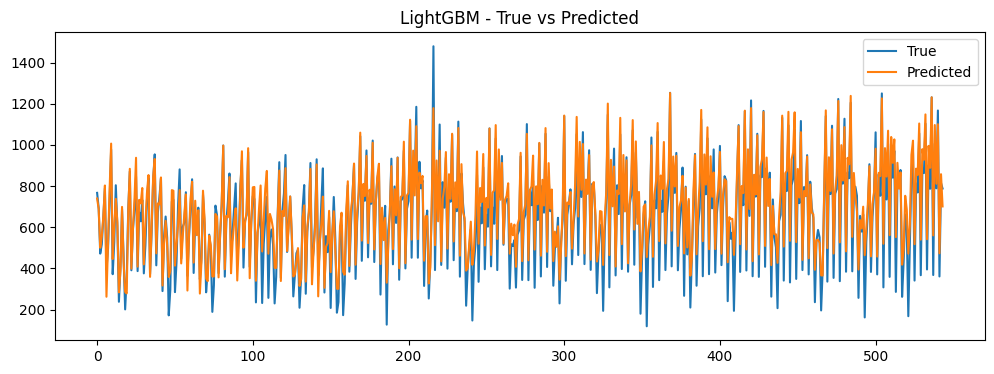

[I 2025-10-27 16:25:36,319] A new study created in memory with name: no-name-3c176b96-df70-4e14-94e8-cc659b01978d
[I 2025-10-27 16:25:36,667] Trial 0 finished with value: 31.99275443133186 and parameters: {'learning_rate': 0.25716901603024106, 'max_depth': 9, 'subsample': 0.8617121516263861, 'colsample_bytree': 0.8763467115735311, 'min_child_weight': 6, 'gamma': 4.015689694629174, 'lambda': 0.18286950878116315, 'alpha': 0.07278164097576537}. Best is trial 0 with value: 31.99275443133186.
[I 2025-10-27 16:25:38,619] Trial 1 finished with value: 62.86880807315602 and parameters: {'learning_rate': 0.024099136602354104, 'max_depth': 6, 'subsample': 0.7636864434202515, 'colsample_bytree': 0.6600605311624784, 'min_child_weight': 11, 'gamma': 3.7416539665448614, 'lambda': 4.43550083662441, 'alpha': 0.0017682988400539168}. Best is trial 0 with value: 31.99275443133186.
[I 2025-10-27 16:25:38,874] Trial 2 finished with value: 43.91124175576603 and parameters: {'learning_rate': 0.281598390123452

XGBoost - MAE: 22.03, RMSE: 32.90


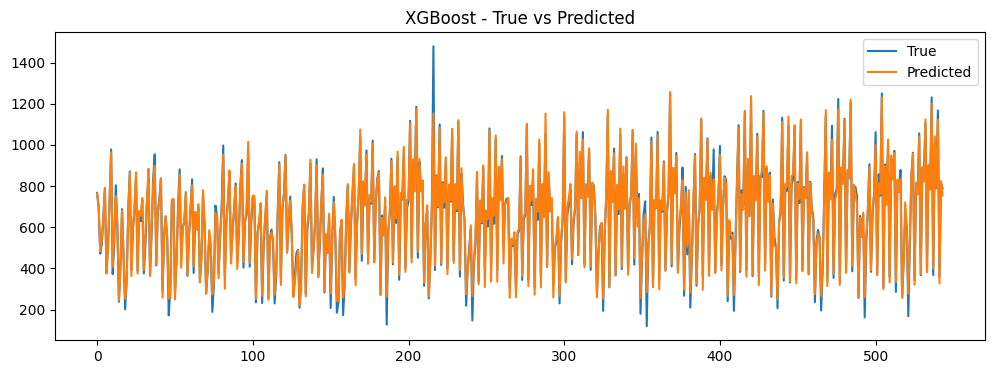

[I 2025-10-27 16:26:02,208] A new study created in memory with name: no-name-809d2448-2868-4f4d-a922-01bb74bd277a
[I 2025-10-27 16:26:07,646] Trial 0 finished with value: 23.188950220774625 and parameters: {'iterations': 722, 'depth': 6, 'learning_rate': 0.12576836704725136}. Best is trial 0 with value: 23.188950220774625.
[I 2025-10-27 16:26:15,519] Trial 1 finished with value: 21.952846346230952 and parameters: {'iterations': 841, 'depth': 6, 'learning_rate': 0.061793571395009454}. Best is trial 1 with value: 21.952846346230952.
[I 2025-10-27 16:26:23,944] Trial 2 finished with value: 47.99811216148447 and parameters: {'iterations': 385, 'depth': 9, 'learning_rate': 0.16056165523353136}. Best is trial 1 with value: 21.952846346230952.
[I 2025-10-27 16:26:36,883] Trial 3 finished with value: 20.534125421377873 and parameters: {'iterations': 888, 'depth': 5, 'learning_rate': 0.04117020355093761}. Best is trial 3 with value: 20.534125421377873.
[I 2025-10-27 16:26:40,657] Trial 4 finish

CatBoost - MAE: 19.87, RMSE: 29.59


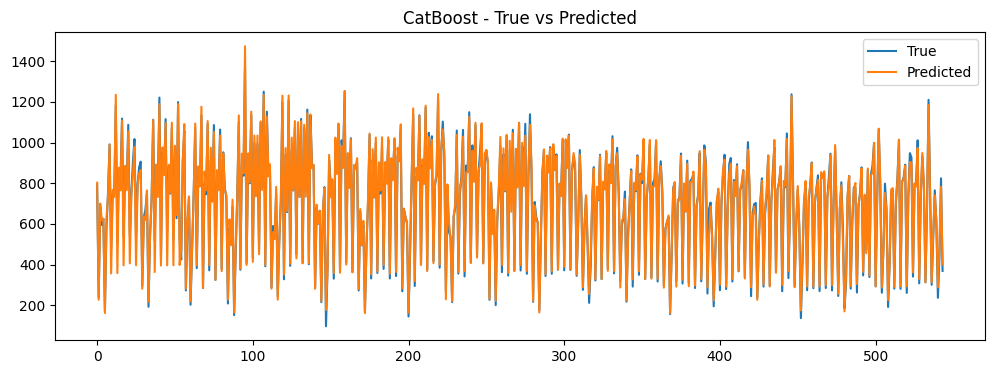

[I 2025-10-27 16:31:49,446] A new study created in memory with name: no-name-a63d245e-66c0-4d42-8f39-5ee60c65bb23


  0%|          | 0/40 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 55.9246
[I 2025-10-27 16:31:49,832] Trial 0 finished with value: 41.8119216444831 and parameters: {'learning_rate': 0.23825944542874689, 'num_leaves': 24, 'max_depth': 10, 'feature_fraction': 0.7234408227704358, 'bagging_fraction': 0.631289987017718, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 0 with value: 41.8119216444831.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 44.6708
[I 2025-10-27 16:31:50,201] Trial 1 finished with value: 32.46046381096449 and parameters: {'learning_rate': 0.200354814686858, 'num_leaves': 95, 'max_depth': 4, 'feature_fraction': 0.6066840849456253, 'bagging_fraction': 0.6477045529975368, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 1 with value: 32.46046381096449.
Training until validation scores don't improve for 50 

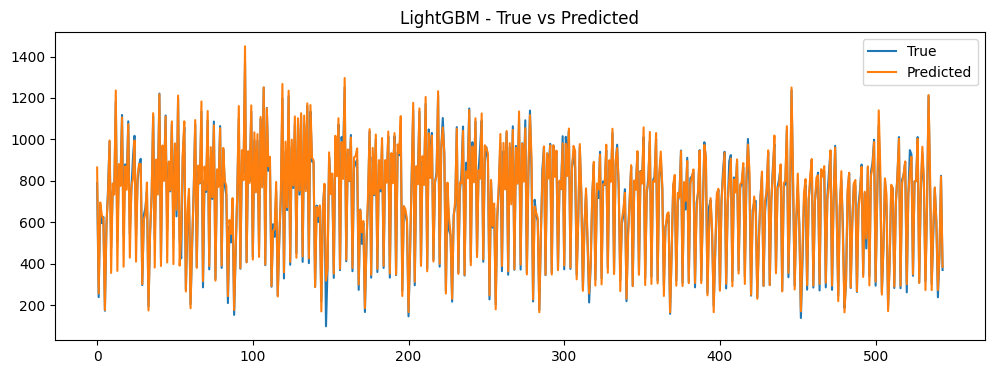

[I 2025-10-27 16:32:06,287] A new study created in memory with name: no-name-bbdb5323-893d-4c07-9f08-54476736bf38
[I 2025-10-27 16:32:06,759] Trial 0 finished with value: 23.99382995156681 and parameters: {'learning_rate': 0.1317847896306337, 'max_depth': 10, 'subsample': 0.9604671081723378, 'colsample_bytree': 0.8368339040012247, 'min_child_weight': 19, 'gamma': 4.808149345171337, 'lambda': 0.003808979589216769, 'alpha': 6.9129874811025545}. Best is trial 0 with value: 23.99382995156681.
[I 2025-10-27 16:32:07,188] Trial 1 finished with value: 25.614229819353888 and parameters: {'learning_rate': 0.11913194512942159, 'max_depth': 11, 'subsample': 0.654523631676578, 'colsample_bytree': 0.7432520818449655, 'min_child_weight': 19, 'gamma': 1.1293965970995008, 'lambda': 7.081182468024985, 'alpha': 0.651790867849967}. Best is trial 0 with value: 23.99382995156681.
[I 2025-10-27 16:32:08,277] Trial 2 finished with value: 33.455258818233716 and parameters: {'learning_rate': 0.0452824529152235

XGBoost - MAE: 19.03, RMSE: 28.45


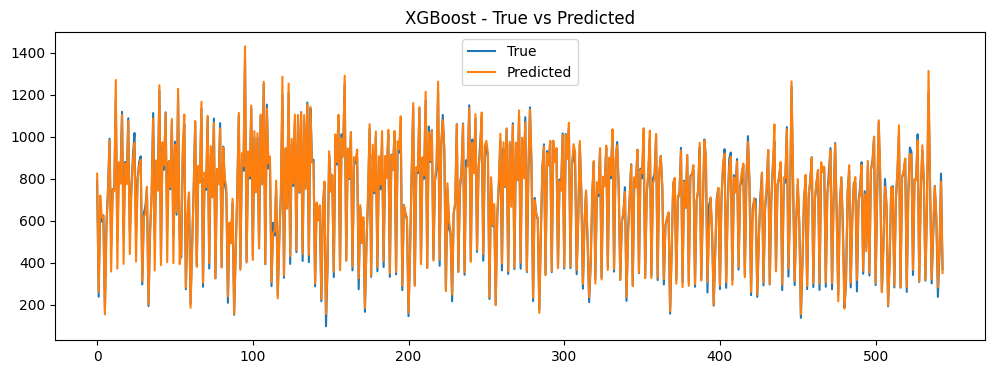

[I 2025-10-27 16:32:24,970] A new study created in memory with name: no-name-a335c3c2-f4e0-4acf-b3ed-0762de89a853
[I 2025-10-27 16:32:27,922] Trial 0 finished with value: 33.47641909103507 and parameters: {'iterations': 247, 'depth': 6, 'learning_rate': 0.2805738729493424}. Best is trial 0 with value: 33.47641909103507.
[I 2025-10-27 16:32:32,645] Trial 1 finished with value: 39.149265240502835 and parameters: {'iterations': 371, 'depth': 9, 'learning_rate': 0.28230797463271257}. Best is trial 0 with value: 33.47641909103507.
[I 2025-10-27 16:32:43,385] Trial 2 finished with value: 28.734561369543457 and parameters: {'iterations': 645, 'depth': 9, 'learning_rate': 0.2589182476683541}. Best is trial 2 with value: 28.734561369543457.
[I 2025-10-27 16:32:51,405] Trial 3 finished with value: 31.882575902954787 and parameters: {'iterations': 907, 'depth': 8, 'learning_rate': 0.09503537354149806}. Best is trial 2 with value: 28.734561369543457.
[I 2025-10-27 16:32:59,111] Trial 4 finished wi

CatBoost - MAE: 19.72, RMSE: 28.99


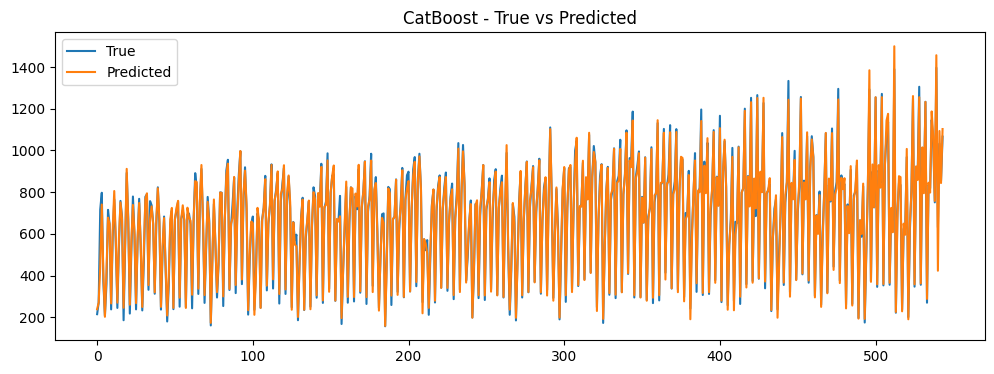

[I 2025-10-27 16:36:28,668] A new study created in memory with name: no-name-1240c88d-3305-4c6a-973a-81eb37e66c97


  0%|          | 0/40 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 43.0235
[I 2025-10-27 16:36:29,188] Trial 0 finished with value: 32.387257183476606 and parameters: {'learning_rate': 0.19871067198092063, 'num_leaves': 70, 'max_depth': 9, 'feature_fraction': 0.6828445543348842, 'bagging_fraction': 0.7478374783417754, 'bagging_freq': 5, 'min_child_samples': 45}. Best is trial 0 with value: 32.387257183476606.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 125.71
[I 2025-10-27 16:36:29,590] Trial 1 finished with value: 101.29559870649948 and parameters: {'learning_rate': 0.01170756901588078, 'num_leaves': 121, 'max_depth': 9, 'feature_fraction': 0.7835246422084552, 'bagging_fraction': 0.9179024091868415, 'bagging_freq': 4, 'min_child_samples': 79}. Best is trial 0 with value: 32.387257183476606.
Training until validation scores don't improve 

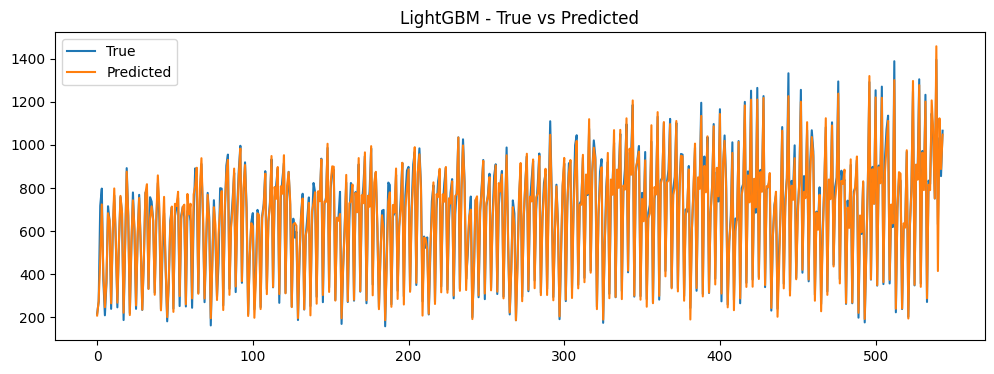

[I 2025-10-27 16:36:44,587] A new study created in memory with name: no-name-6003b3c8-c08f-472d-97a1-1fa41c6daecd
[I 2025-10-27 16:36:45,550] Trial 0 finished with value: 33.52641161750345 and parameters: {'learning_rate': 0.05497292298253981, 'max_depth': 8, 'subsample': 0.7259936389532904, 'colsample_bytree': 0.7083310315656426, 'min_child_weight': 2, 'gamma': 3.6756540471811867, 'lambda': 0.021589835118406883, 'alpha': 0.4352015870534806}. Best is trial 0 with value: 33.52641161750345.
[I 2025-10-27 16:36:47,960] Trial 1 finished with value: 24.243417515474206 and parameters: {'learning_rate': 0.02669080948035183, 'max_depth': 10, 'subsample': 0.7884975680334619, 'colsample_bytree': 0.8004096304091688, 'min_child_weight': 13, 'gamma': 1.1642667480097386, 'lambda': 0.002884442011565951, 'alpha': 0.004529149328017491}. Best is trial 1 with value: 24.243417515474206.
[I 2025-10-27 16:36:48,822] Trial 2 finished with value: 25.624065847957837 and parameters: {'learning_rate': 0.07063185

XGBoost - MAE: 18.71, RMSE: 28.04


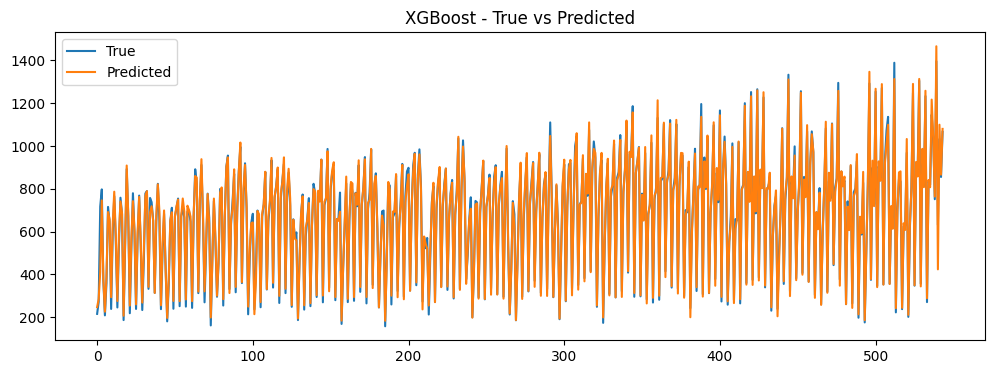

[I 2025-10-27 16:36:59,457] A new study created in memory with name: no-name-126a3bda-9978-4f55-8029-1a1252480a1a
[I 2025-10-27 16:37:03,588] Trial 0 finished with value: 23.73113468894121 and parameters: {'iterations': 462, 'depth': 6, 'learning_rate': 0.0586628145066776}. Best is trial 0 with value: 23.73113468894121.
[I 2025-10-27 16:37:05,789] Trial 1 finished with value: 24.7905058514593 and parameters: {'iterations': 693, 'depth': 4, 'learning_rate': 0.25621867886597727}. Best is trial 0 with value: 23.73113468894121.
[I 2025-10-27 16:37:10,272] Trial 2 finished with value: 23.402331447152285 and parameters: {'iterations': 861, 'depth': 5, 'learning_rate': 0.17610968260795176}. Best is trial 2 with value: 23.402331447152285.
[I 2025-10-27 16:37:11,620] Trial 3 finished with value: 24.10577764979355 and parameters: {'iterations': 112, 'depth': 5, 'learning_rate': 0.23018489070141984}. Best is trial 2 with value: 23.402331447152285.
[I 2025-10-27 16:37:17,877] Trial 4 finished with

CatBoost - MAE: 22.60, RMSE: 30.91


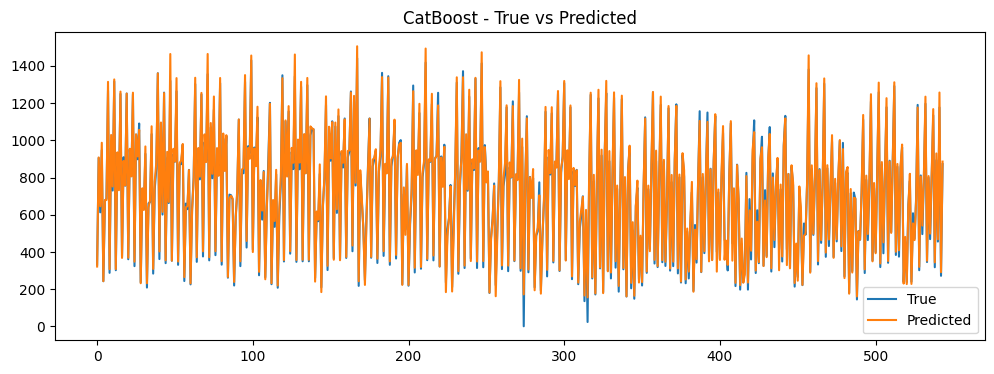

[I 2025-10-27 16:41:14,373] A new study created in memory with name: no-name-74bd27e7-aac8-46f8-9338-068cb4ed1c0e


  0%|          | 0/40 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 58.2523
[I 2025-10-27 16:41:15,044] Trial 0 finished with value: 39.571921812493464 and parameters: {'learning_rate': 0.059740570382588155, 'num_leaves': 125, 'max_depth': 11, 'feature_fraction': 0.6984383197009842, 'bagging_fraction': 0.6858691379897157, 'bagging_freq': 2, 'min_child_samples': 60}. Best is trial 0 with value: 39.571921812493464.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 33.6676
[I 2025-10-27 16:41:15,337] Trial 1 finished with value: 24.466493083709715 and parameters: {'learning_rate': 0.22462804049807228, 'num_leaves': 96, 'max_depth': 12, 'feature_fraction': 0.8651075323883154, 'bagging_fraction': 0.6873369546080961, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 1 with value: 24.466493083709715.
Training until validation scores don't improve for 50 ro

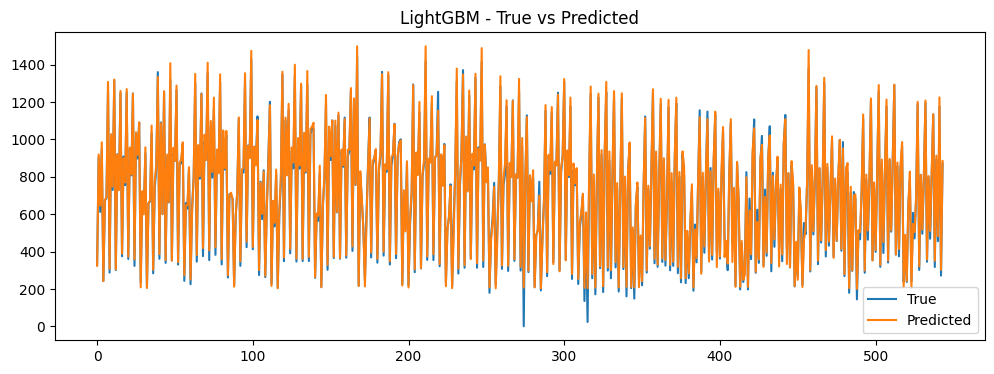

[I 2025-10-27 16:41:29,988] A new study created in memory with name: no-name-4bb89f8b-d152-4e2b-ba81-4dd8397e01db
[I 2025-10-27 16:41:31,641] Trial 0 finished with value: 31.511353773229263 and parameters: {'learning_rate': 0.018256261969902432, 'max_depth': 9, 'subsample': 0.879151401834672, 'colsample_bytree': 0.7676217482950813, 'min_child_weight': 17, 'gamma': 3.507805358901294, 'lambda': 0.05475983553703759, 'alpha': 0.0012304623338916455}. Best is trial 0 with value: 31.511353773229263.
[I 2025-10-27 16:41:32,045] Trial 1 finished with value: 36.211944467881146 and parameters: {'learning_rate': 0.13416839293577226, 'max_depth': 6, 'subsample': 0.7610249734074536, 'colsample_bytree': 0.6192218463307249, 'min_child_weight': 18, 'gamma': 3.9924484820187924, 'lambda': 0.26801348583995366, 'alpha': 0.3108010858288461}. Best is trial 0 with value: 31.511353773229263.
[I 2025-10-27 16:41:32,197] Trial 2 finished with value: 30.15561569438261 and parameters: {'learning_rate': 0.286474719

XGBoost - MAE: 22.36, RMSE: 30.75


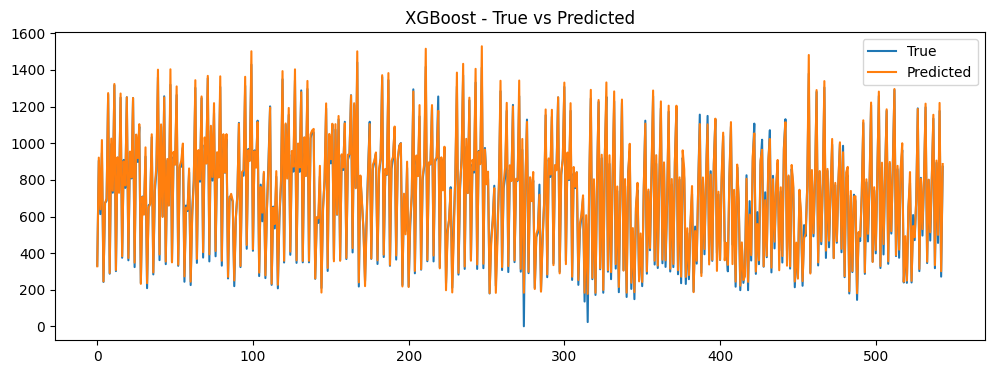

[I 2025-10-27 16:41:47,616] A new study created in memory with name: no-name-ebb77bb0-6044-4fb7-9cad-f85c7e86859f
16:41:47 - cmdstanpy - INFO - Chain [1] start processing
16:41:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-27 16:41:48,835] Trial 0 finished with value: 373.3191661463459 and parameters: {'changepoint_prior_scale': 0.13749031530072725, 'seasonality_prior_scale': 0.9258391860409538, 'holidays_prior_scale': 0.030765241737020402, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 373.3191661463459.
16:41:48 - cmdstanpy - INFO - Chain [1] start processing
16:41:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-27 16:41:51,027] Trial 1 finished with value: 384.33952861807023 and parameters: {'changepoint_prior_scale': 0.24789075230368693, 'seasonality_prior_scale': 8.462028340034049, 'holidays_prior_scale': 0.013812640308614952, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 373.3191661463459.
16:41:51 - cmdstanpy - INFO - Chai

Prophet - MAE: 260.85, RMSE: 315.29


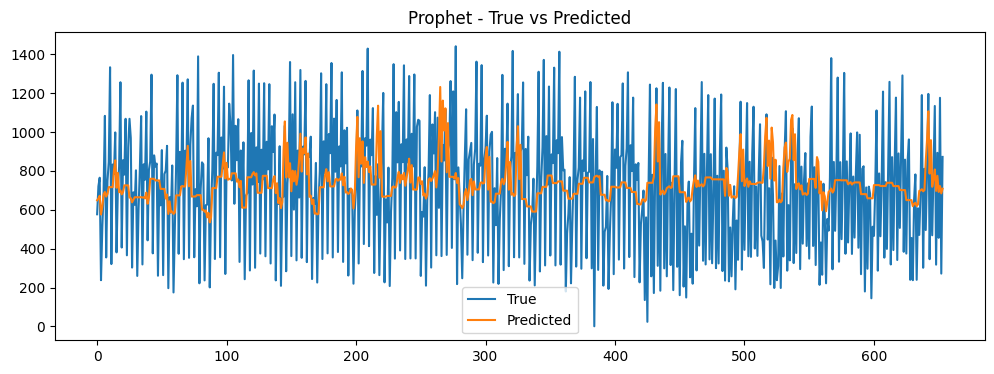

In [51]:
# Пример вызова:
models = universal_pipeline(
    filepath=INPUT_CSV,
    group_by=['date', 'Торговое предприятие'],
    target_cols=list(agg_funcs.keys()),
    agg_funcs=agg_funcs,
    features=features,
    target='Количество блюд',
    cat_features=cat_features,
    regressors=regressors,
    n_trials=40,
    test_size=0.2,
    n_splits=5)

      Model         MAE        RMSE
0  CatBoost   22.600871   30.909129
1  LightGBM   22.839861   30.885915
2   XGBoost   22.356001   30.750874
3   Prophet  260.854758  315.287645


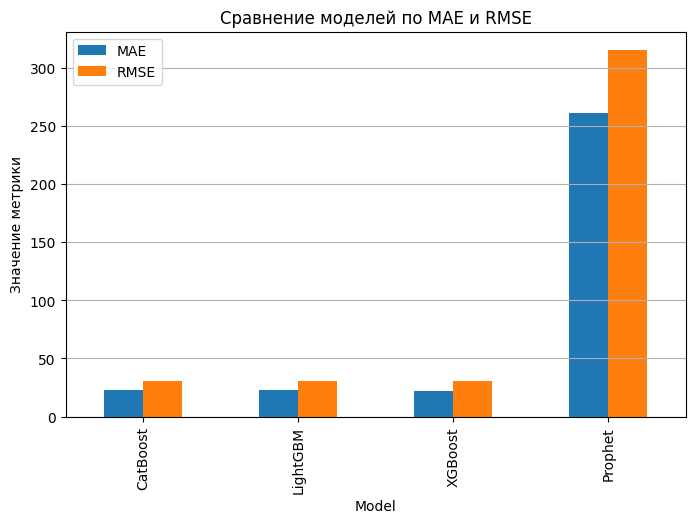

In [52]:
future_preds = models['future_preds']

# Если вы хотите сравнить на тестовой выборке:
# y_test — реальные значения, X_test_sync — тестовые признаки (или valid_df['y'] для Prophet)
# Предполагаем, что у вас есть y_test и valid_df['y']

# Получаем предсказания на тестовой выборке
y_test = models['y_test']
X_test_sync = models['X_test_sync']
preds_cat = models['catboost'].predict(X_test_sync)
preds_lgbm = models['lgbm'].predict(X_test_sync)
X_test_xgb = models['X_test_xgb']
dtest = xgb.DMatrix(X_test_xgb)
preds_xgb = models['xgb'].predict(dtest)
valid_df = models['valid_df']
preds_prophet = models['prophet'].predict(valid_df)['yhat']  # valid_df — валидационная выборка для Prophet

# Считаем метрики
results = []
results.append({
    'Model': 'CatBoost',
    'MAE': mean_absolute_error(y_test, preds_cat),
    'RMSE': mean_squared_error(y_test, preds_cat, squared=False)
})
results.append({
    'Model': 'LightGBM',
    'MAE': mean_absolute_error(y_test, preds_lgbm),
    'RMSE': mean_squared_error(y_test, preds_lgbm, squared=False)
})
results.append({
    'Model': 'XGBoost',
    'MAE': mean_absolute_error(y_test, preds_xgb),
    'RMSE': mean_squared_error(y_test, preds_xgb, squared=False)
})
results.append({
    'Model': 'Prophet',
    'MAE': mean_absolute_error(valid_df['y'], preds_prophet),
    'RMSE': mean_squared_error(valid_df['y'], preds_prophet, squared=False)
})

# Таблица сравнения
results_df = pd.DataFrame(results)
print(results_df)

# График сравнения
results_df.set_index('Model')[['MAE', 'RMSE']].plot(kind='bar', figsize=(8, 5))
plt.title('Сравнение моделей по MAE и RMSE')
plt.ylabel('Значение метрики')
plt.grid(axis='y')
plt.show()

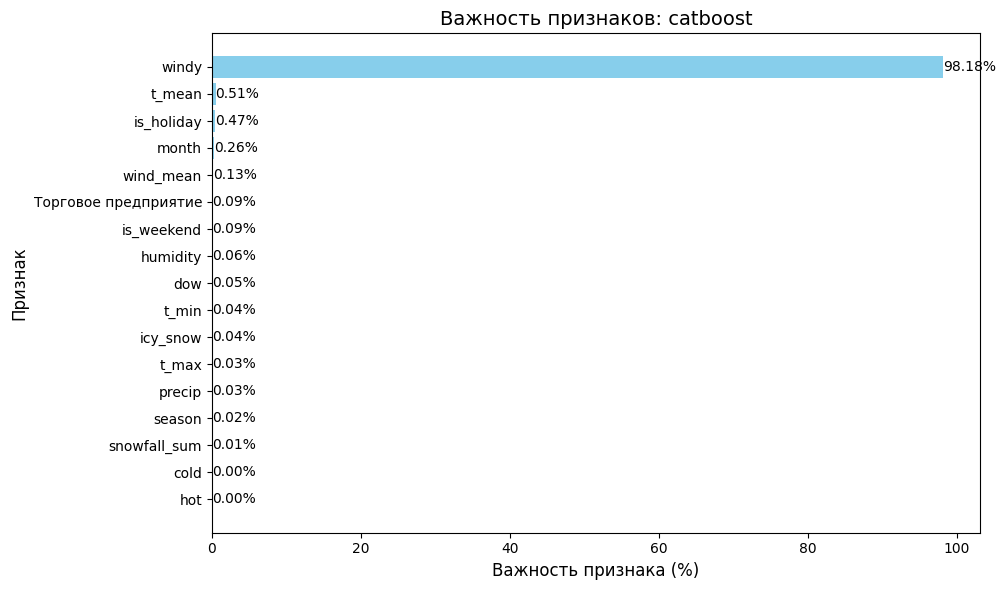

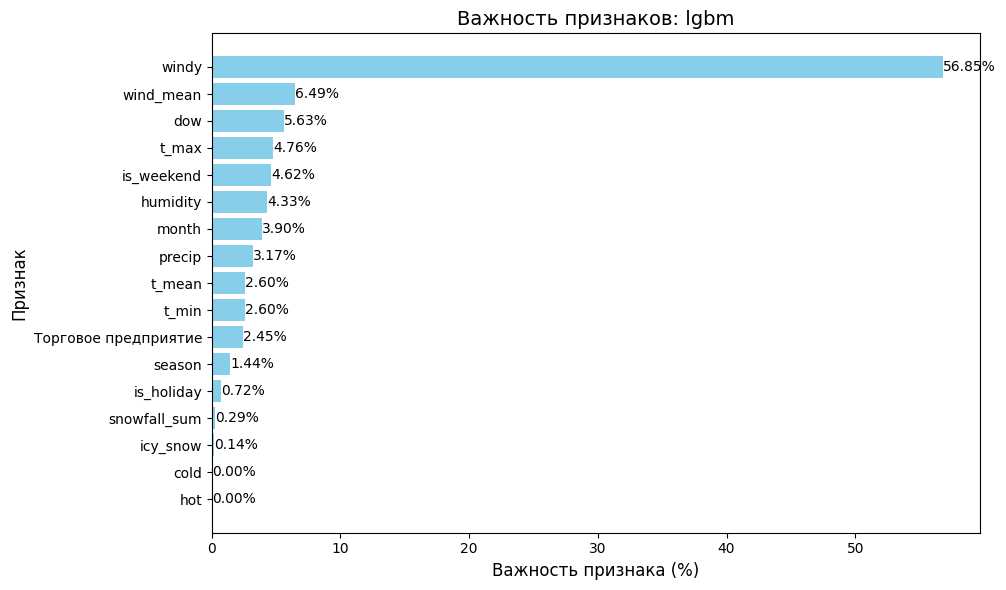

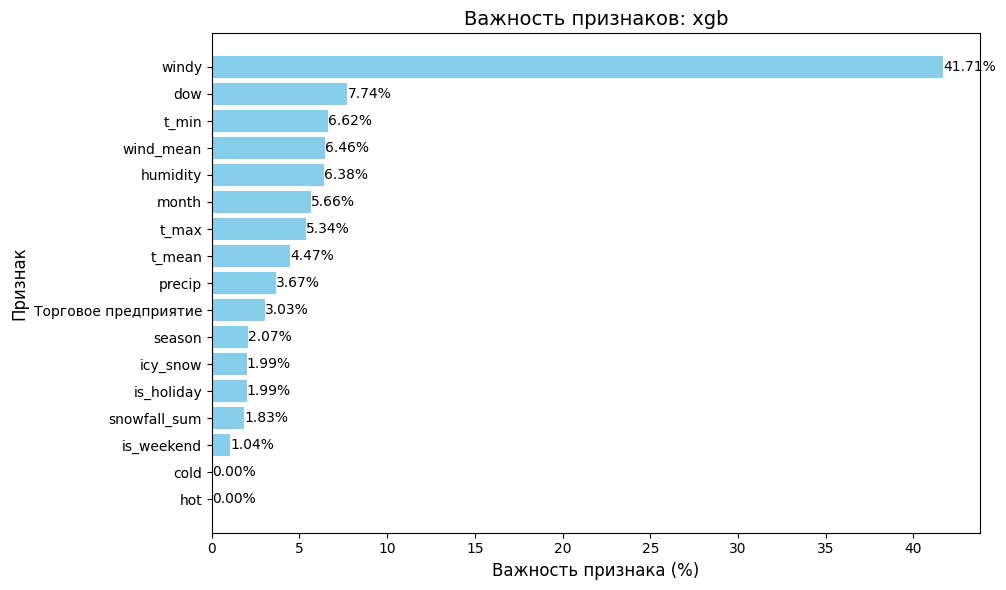

In [53]:
plot_feature_importance(models['catboost'], features, model_type='catboost', save_path='catboost_importance.png')
plot_feature_importance(models['lgbm'], features, model_type='lgbm', save_path='lgbm_importance.png')
plot_feature_importance(models['xgb'], features, model_type='xgb', save_path='xgb_importance.png')

In [56]:
# Сопоставление имён моделей
model_name_map = {
    'catboost': 'catboost',
    'lightgbm': 'lgbm',
    'xgboost': 'xgb',
    'prophet': 'prophet'
}

best_model_name = results_df.sort_values('MAE').iloc[0]['Model'].lower()
best_model_key = model_name_map[best_model_name]

future_df = models['future_df']
future_preds = models['future_preds'][best_model_key]

future_table = future_df[['Торговое предприятие', 'date']].copy()
future_table['prediction'] = future_preds

print(future_table)

   Торговое предприятие       date  prediction
0              Энгельса 2025-09-19  175.240723
1                 Плаза 2025-09-19  175.052185
2             Свердлова 2025-09-19  174.548889
3                Тетрис 2025-09-19  174.724243
4               Анохина 2025-09-19  175.052185
5              Энгельса 2025-09-20  173.856934
6                 Плаза 2025-09-20  174.074585
7             Свердлова 2025-09-20  173.571289
8                Тетрис 2025-09-20  173.340454
9               Анохина 2025-09-20  174.074585
10             Энгельса 2025-09-21  174.234802
11                Плаза 2025-09-21  174.452454
12            Свердлова 2025-09-21  173.949158
13               Тетрис 2025-09-21  173.718323
14              Анохина 2025-09-21  174.452454
15             Энгельса 2025-09-22  169.156616
16                Плаза 2025-09-22  168.955750
17            Свердлова 2025-09-22  168.464783
18               Тетрис 2025-09-22  168.640137
19              Анохина 2025-09-22  168.955750
20           

1. Сохранение лучшей модели

In [58]:
# CatBoost
if best_model_key == 'catboost':
    best_model.save_model('best_catboost.cbm')

# LightGBM
elif best_model_key == 'lgbm':
    best_model.booster_.save_model('best_lgbm.txt')

# XGBoost
elif best_model_key == 'xgb':
    best_model.save_model('best_xgb.model')

# Prophet
elif best_model_key == 'prophet':
    import joblib
    joblib.dump(best_model, 'best_prophet.pkl')

2. Загрузка модели

In [ ]:
# CatBoost
if best_model_key == 'catboost':
    from catboost import CatBoostRegressor
    loaded_model = CatBoostRegressor()
    loaded_model.load_model('best_catboost.cbm')

# LightGBM
elif best_model_key == 'lgbm':
    import lightgbm as lgb
    loaded_model = lgb.Booster(model_file='best_lgbm.txt')

# XGBoost
elif best_model_key == 'xgb':
    import xgboost as xgb
    loaded_model = xgb.Booster()
    loaded_model.load_model('best_xgb.model')

# Prophet
elif best_model_key == 'prophet':
    import joblib
    loaded_model = joblib.load('best_prophet.pkl')

3. Использование загруженной модели для предсказания

In [ ]:
# Для CatBoost и LightGBM (sklearn API)
if best_model_key == 'catboost':
    preds = loaded_model.predict(future_df[features])
elif best_model_key == 'lgbm':
    preds = loaded_model.predict(future_df[features])

# Для XGBoost (низкоуровневый API)
elif best_model_name == 'xgb':
    dmatrix = xgb.DMatrix(future_df[features])
    preds = loaded_model.predict(dmatrix)

# Для Prophet
elif best_model_name == 'prophet':
    preds = loaded_model.predict(future_df.rename(columns={'date': 'ds'}))['yhat']

# Формируем таблицу
future_table = future_df[['Торговое предприятие', 'date']].copy()
future_table['prediction'] = preds
print(future_table)